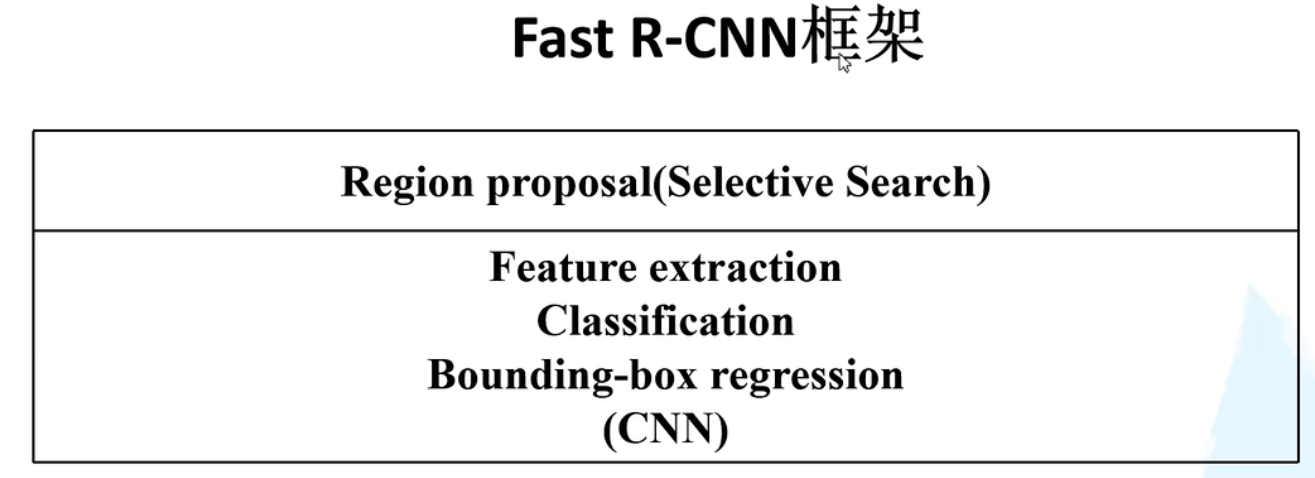

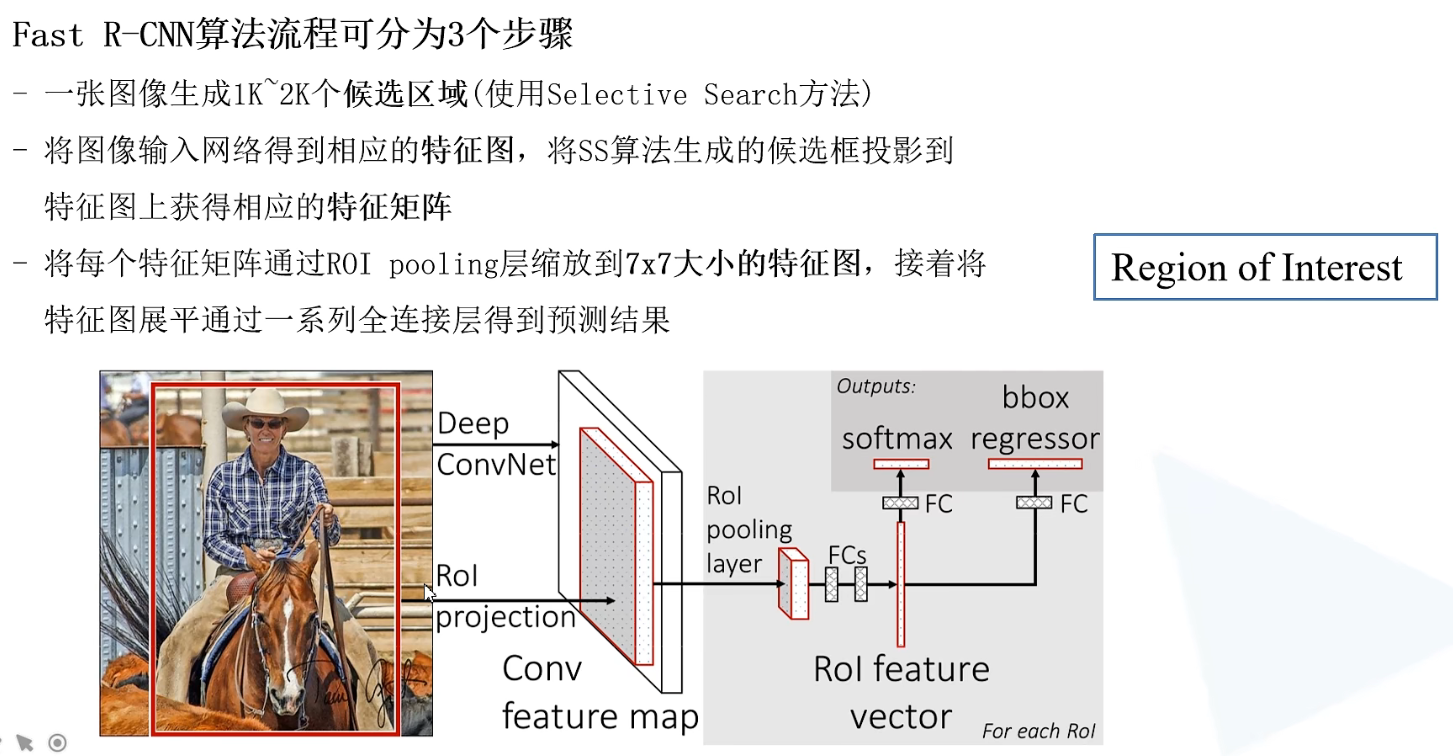

* 拿到一张图片，使用selective search选取建议框
* 将原始图片输入卷积神经网络之中，获取特征图（最后一次池化前的卷积计算结果）
* 对每个建议框，从特征图中找到对应位置（按照比例寻找即可），截取出特征框（深度保持不变）
* 将每个特征框划分为 H * W个网格（论文中是 7 * 7 ），在每个网格内进行池化（即每个网格内取最大值），这就是ROI池化。这样每个特征框就被转化为了 7 * 7 * C 矩阵(其中C为深度)
* 对每个矩阵拉长为一个向量，分别作为之后的全连接层的输入
* 全连接层的输出有两个，计算分类得分和bounding box回归（bounding box表示预测时要画的框）。前者是sotfmax的21类分类器（假设有20个类别+背景类），输出属于每一类的概率（所有建议框的输出构成得分矩阵）；后者是输出一个 20 * 4 的矩阵，4表示(x, y, w, h)，20表示20个类，这里是对20个类分别计算了框的位置和大小
* 对输出的得分矩阵使用非极大抑制方法选出少数框，对每一个框选择概率最大的类作为标注的类，根据网络结构的第二个输出，选择对应类下的位置和大小对图像进行标注

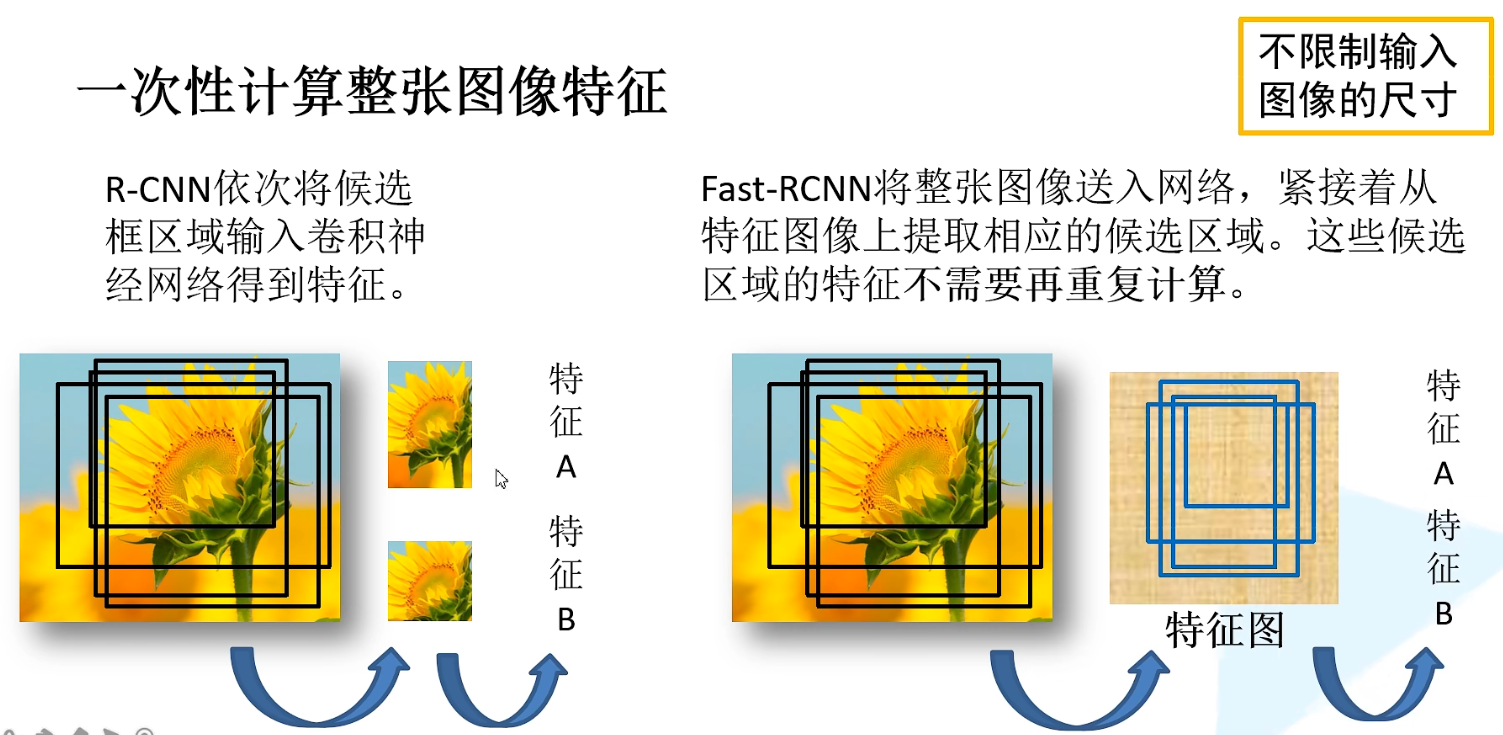

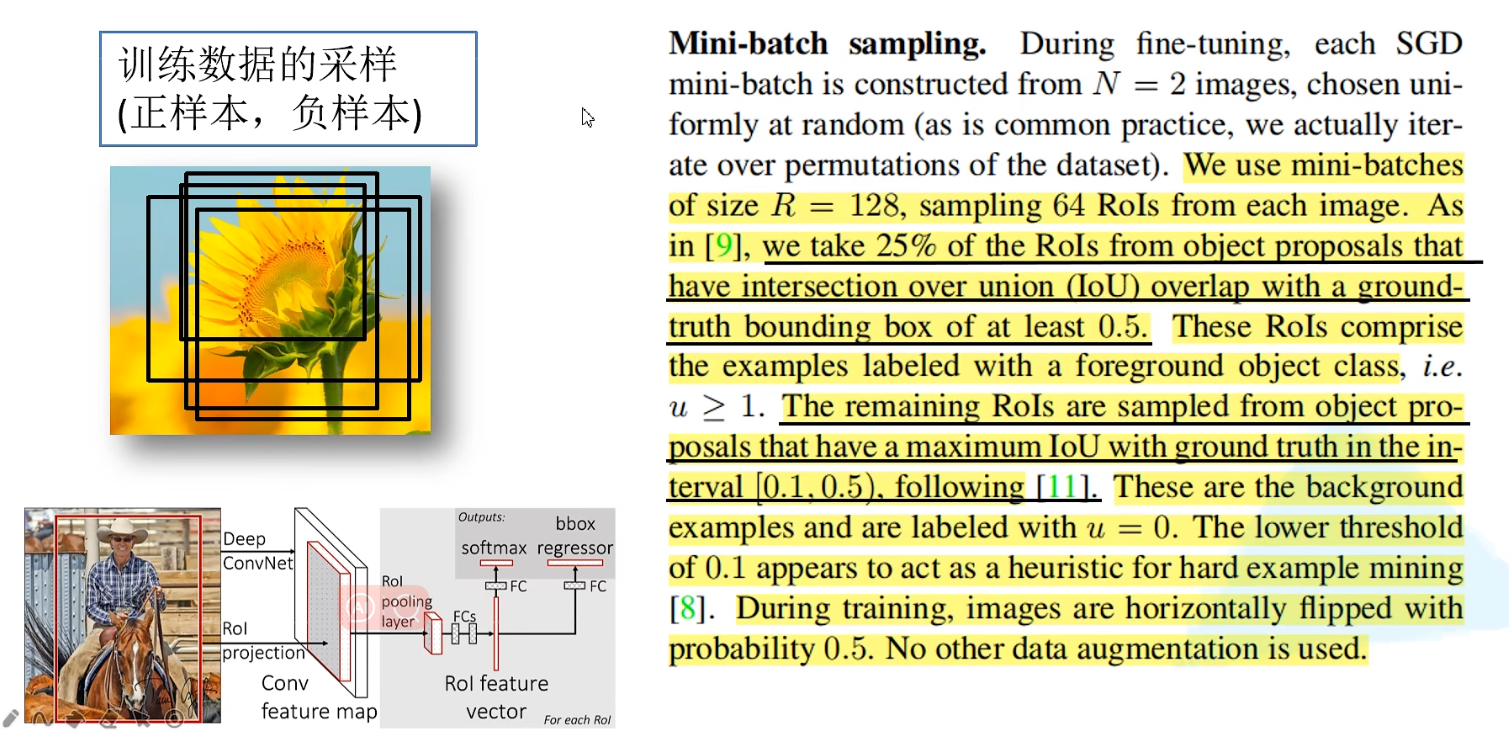

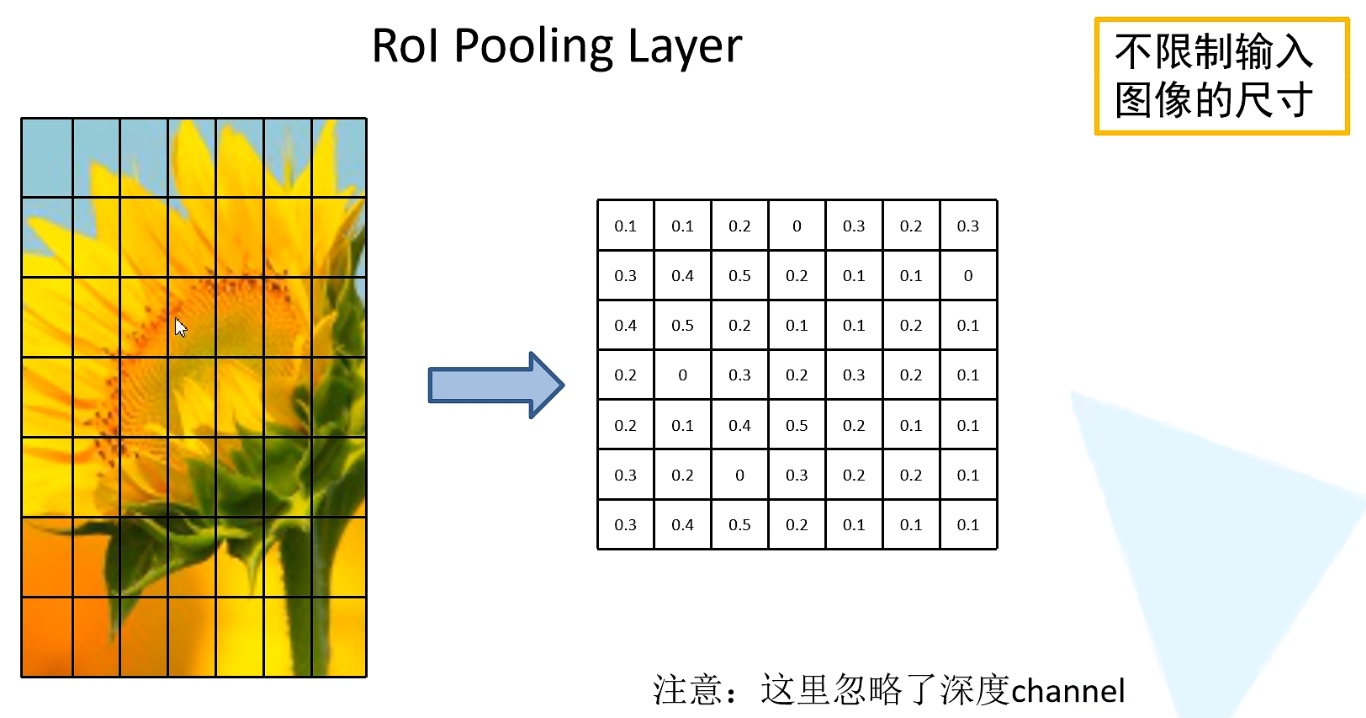

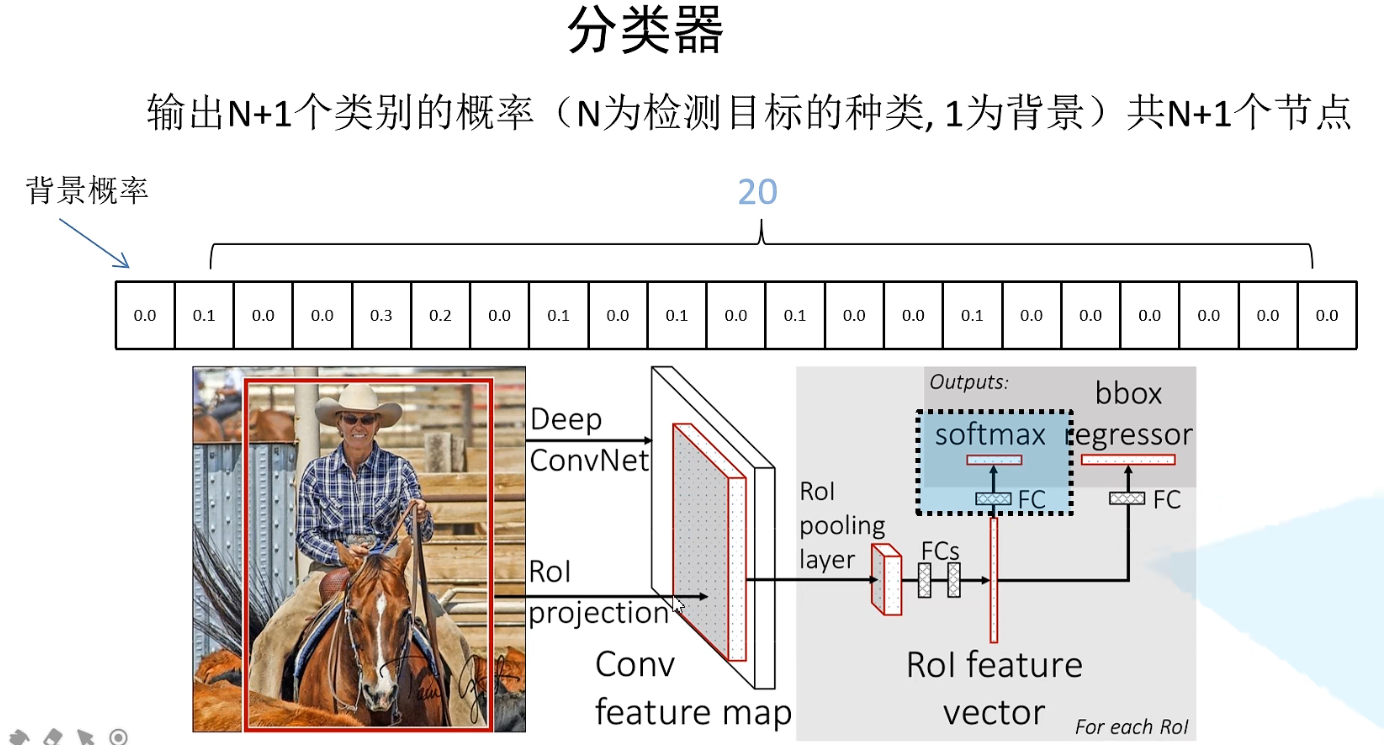

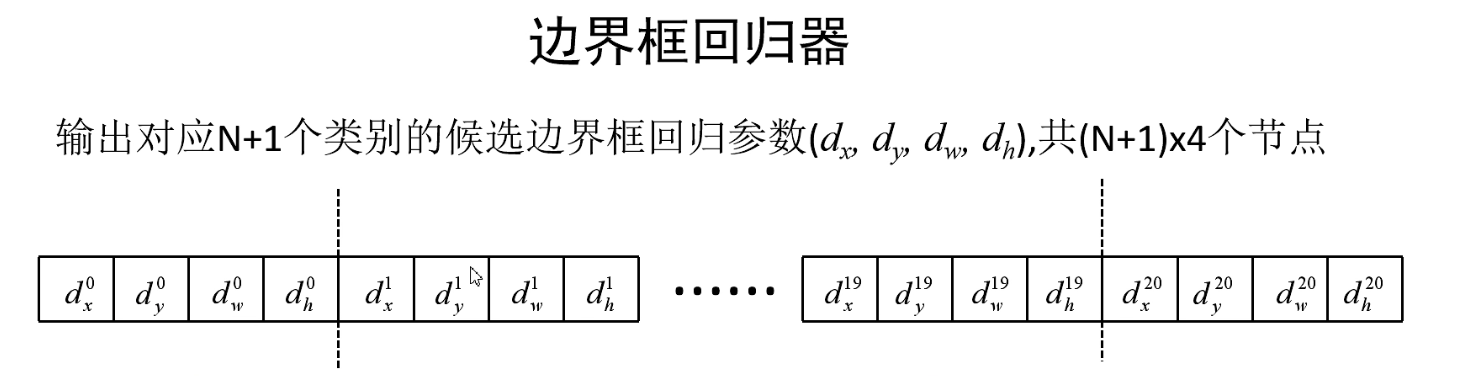

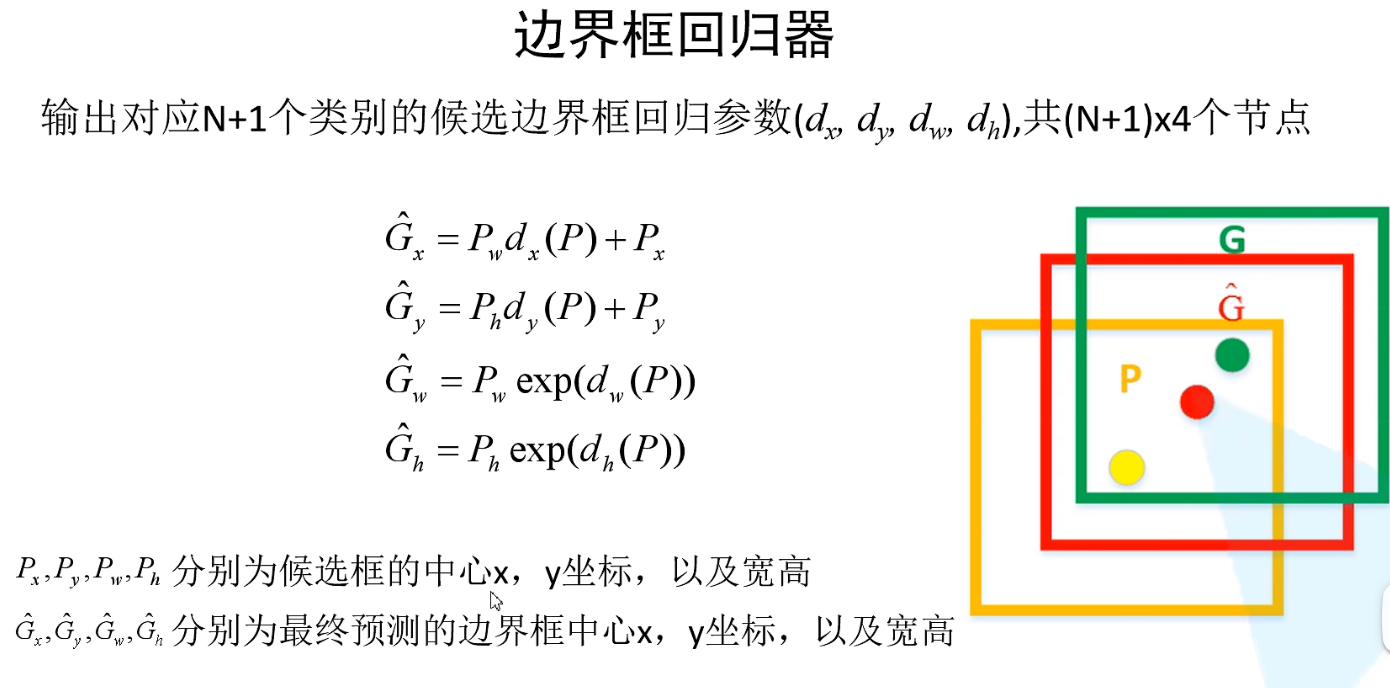

论文中使用了多种网络结构进行训练，这里以VGG-16（AlexNet之后的又一经典网络）为例。

最开始仍然是在ImageNet数据集上训练一个1000类的分类网络

然后对模型进行“三个变动”

* 将最后一个最大池化层换成ROI池化层
* 将最后一个全连接层和后面的softmax1000分类器换成两个并行层，一个是全连接层1+21分类器，另一个是全连接层2+表示每个类预测框位置的输出
* 输入的不再只是图片，还有提取到的建议框位置信息

使用变动后的模型，在标注过的图像数据上继续训练，训练时要输入图像、标注（这里将人为标注的框称为ground truth）和建议框信息。这里为了提高训练速度，采取了小批量梯度下降的方式，每次使用**2张图片的128张建议框**（每张图片取64个建议框）更新参数。

每次更新参数的训练步骤如下

* 2张图像直接经过前面的卷积层获得特征图
* 根据ground truth标注所有建议框的类别。具体步骤为，对每一个类别的ground truth，与它的iou大于0.5的建议框标记为groud truth的类别，对于与ground truth的iou介于0.1到0.5之间的建议框，标注为背景类别
* 每张图片随机选取64个建议框（要控制背景类的建议框占75%），提取出特征框
* 特征框继续向下计算，进入两个并行层计算损失函数（损失函数具体计算见下面）
* 反向传播更新参数

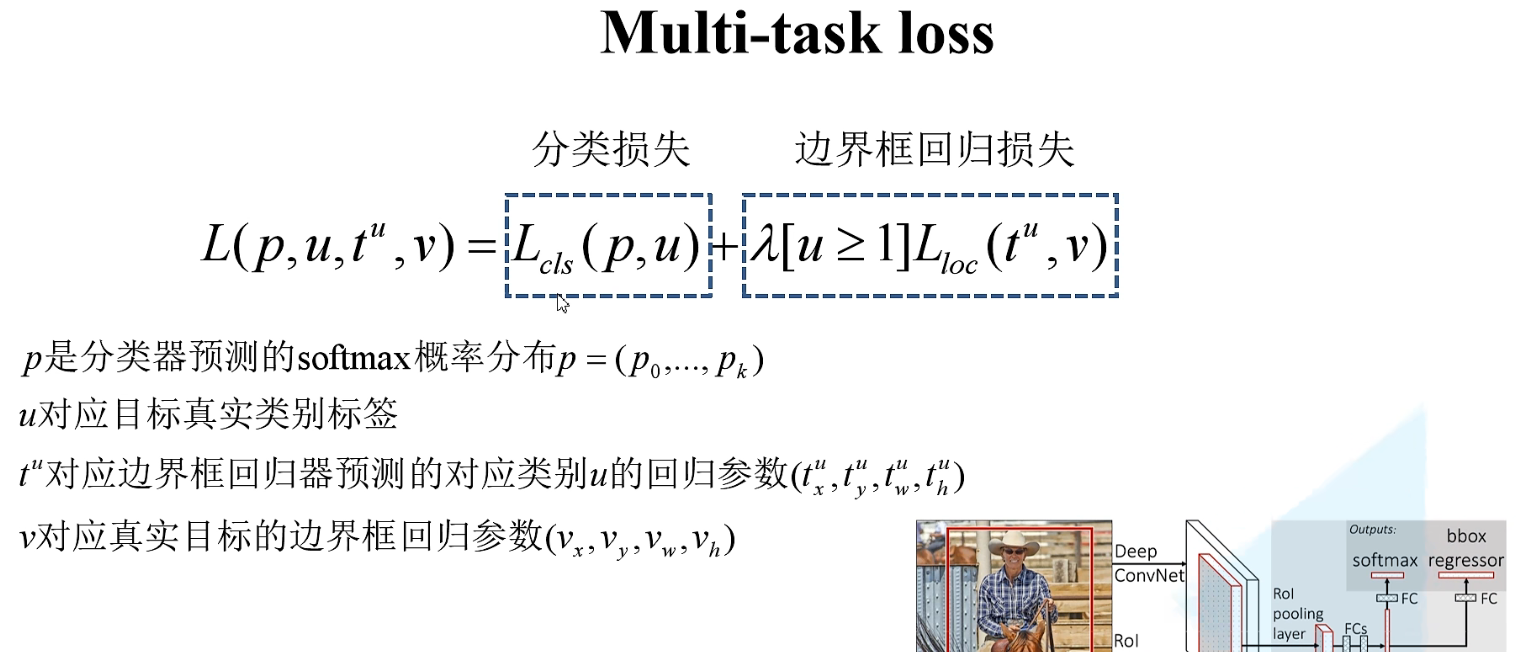

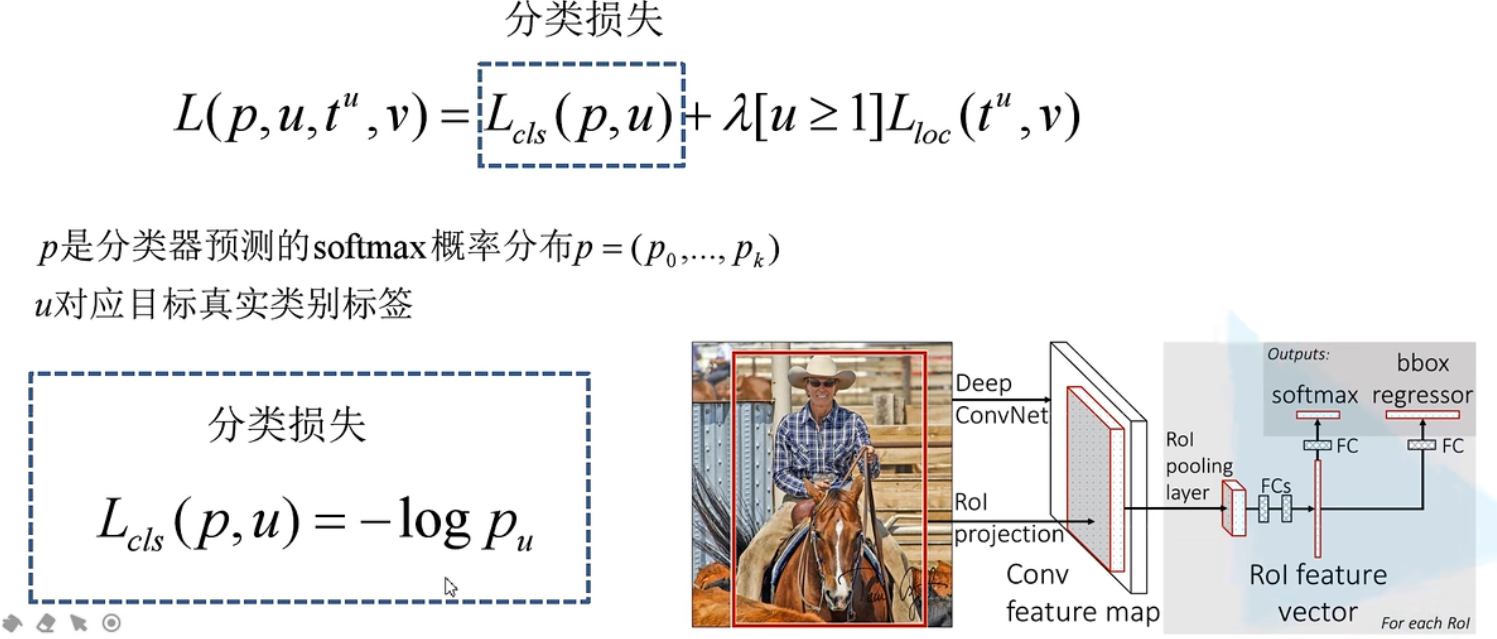

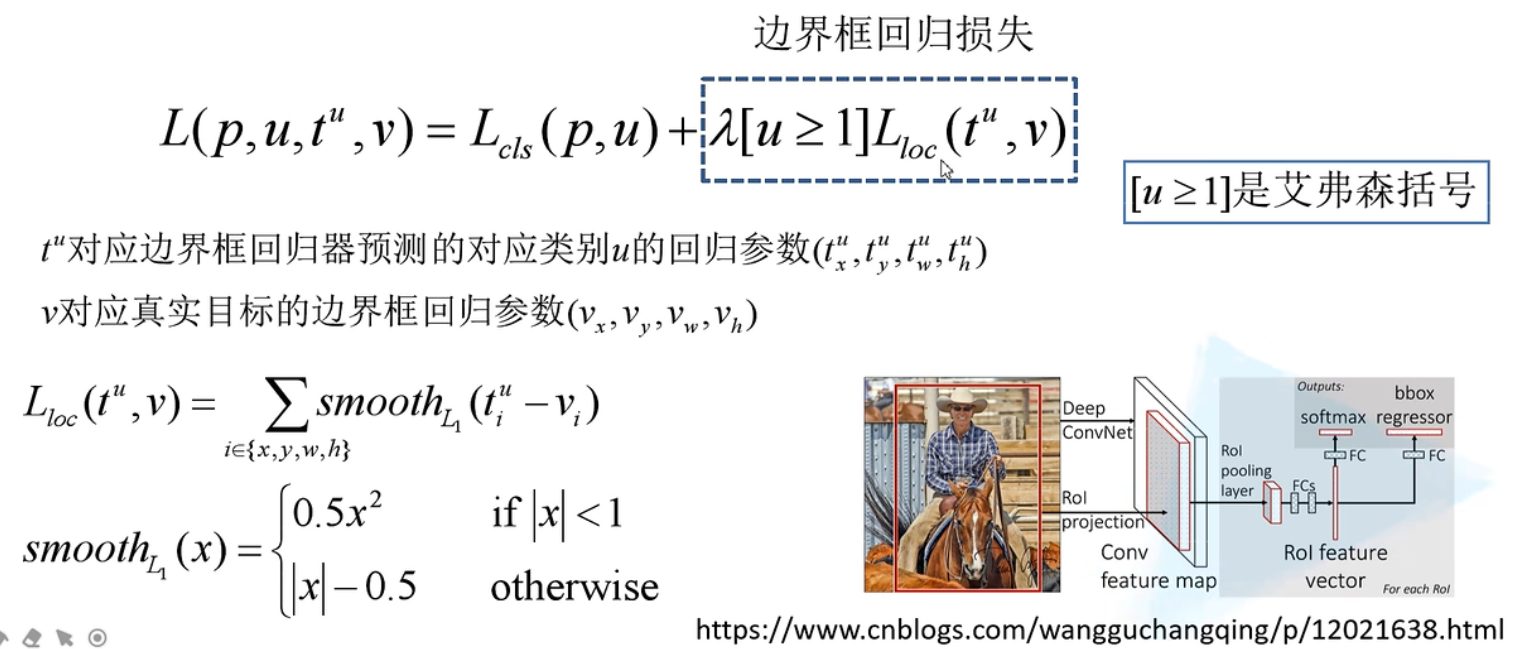

艾弗森括号表示u>=1时，为1，反之为0（背景），就是只有预测框中有真实类别（正样本）的，才会去计算边界框回归参数。

真实边界框回归参数就是边界框回归器那张图片中公式的逆函数

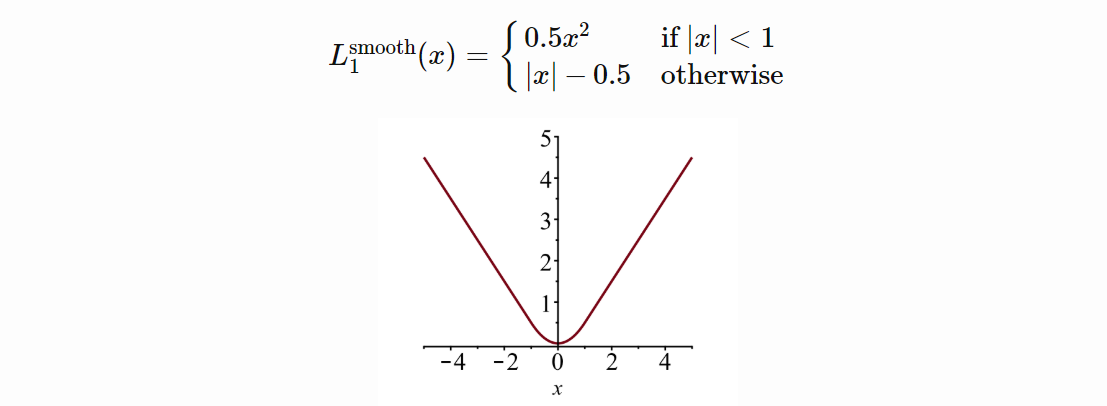